# **Forecasting challenge**

Alejandro Mendoza Medina
Jaime Álvarez Urueña

https://www.kaggle.com/competitions/probabilistic-forecasting-i-temperature

In [ ]:
# import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor

## **Dataset Analysis** 

In [163]:
train_and_public_df = pd.read_csv('data/temperature-forecasting-challenge/train_and_Public.csv', index_col=['id'])
train_and_public_df['date'] = pd.to_datetime(train_and_public_df['date'])
for col in train_and_public_df.select_dtypes(include=['float64']).columns:
    train_and_public_df[col] = train_and_public_df[col].astype('float32')

train_df = train_and_public_df[:64320]
test_df = train_and_public_df[64320:]

train_and_public_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 67008 entries, 0 to 67007
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         67008 non-null  datetime64[ns]
 1   feature_AA   67008 non-null  float32       
 2   feature_AB   67008 non-null  float32       
 3   feature_BA   67008 non-null  float32       
 4   feature_BB   67008 non-null  float32       
 5   feature_CA   67008 non-null  float32       
 6   feature_CB   67008 non-null  float32       
 7   Temperature  67008 non-null  float32       
dtypes: datetime64[ns](1), float32(7)
memory usage: 2.8 MB


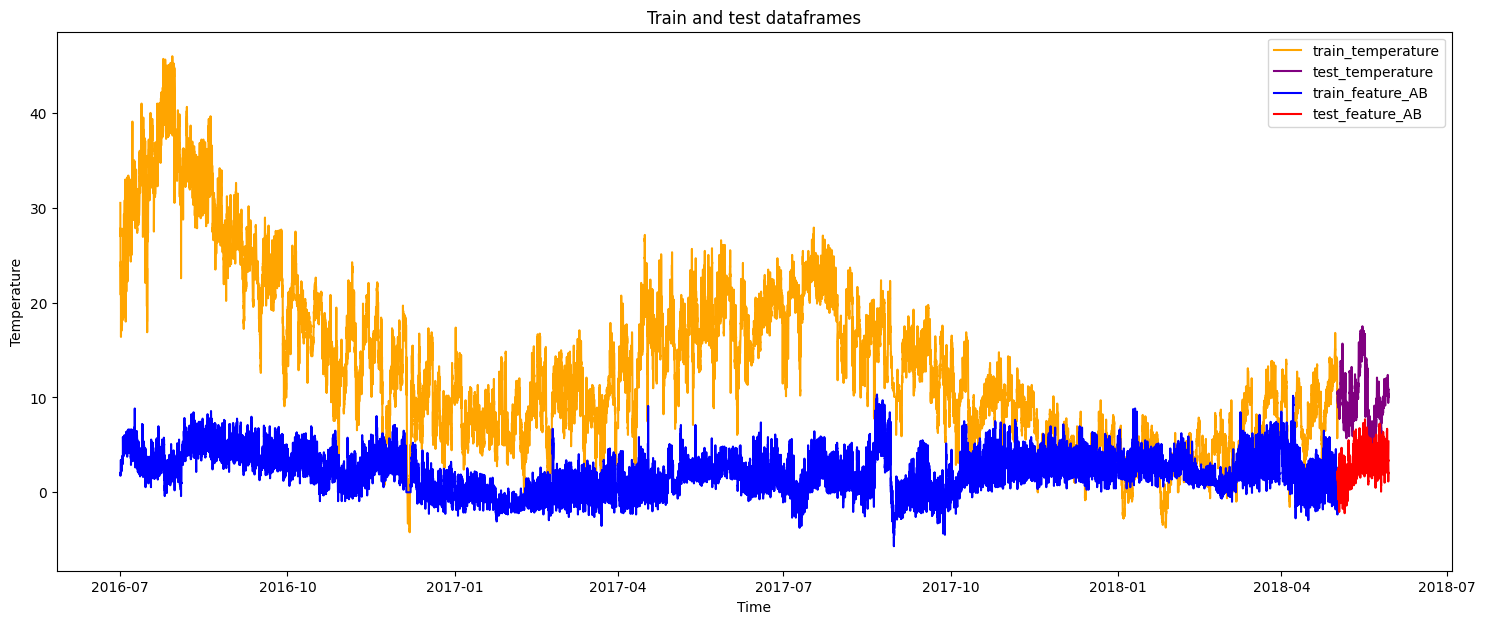

In [164]:
plt.figure(figsize=(18,7))
plt.plot(train_df['date'], train_df['Temperature'], label='train_temperature', color='orange')
plt.plot(test_df['date'], test_df['Temperature'], label='test_temperature', color='purple')
plt.plot(train_df['date'], train_df['feature_AB'], label='train_feature_AB', color='blue')
plt.plot(test_df['date'], test_df['feature_AB'], label='test_feature_AB', color='red')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Train and test dataframes")
plt.legend()
plt.show()

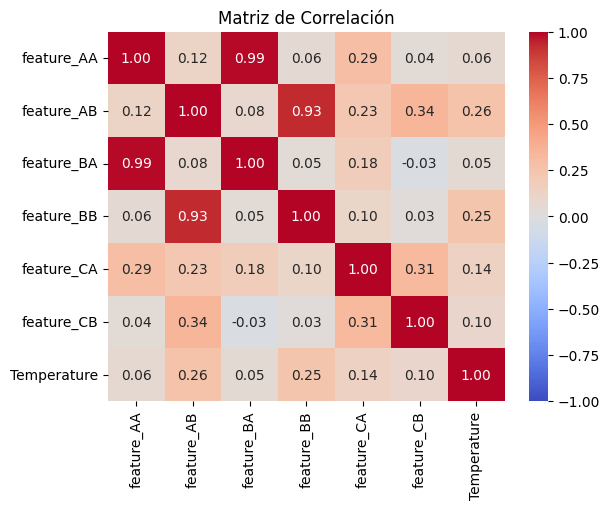

In [38]:
numerical_columns = train_df.select_dtypes(include=['float32']).columns
corr_matrix = train_df[numerical_columns].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()

## **Models**

In [62]:
quantiles = [0.025,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,0.975]
quantile_mapping = {
    0.95: ('0.025', '0.975'),
    0.9: ('0.05', '0.95'),
    0.8: ('0.10', '0.90'),
    0.7: ('0.15', '0.85'),
    0.6: ('0.20', '0.80'),
    0.5: ('0.25', '0.75'),
    0.4: ('0.30', '0.70'),
    0.3: ('0.35', '0.65'),
    0.2: ('0.40', '0.60'),
    0.1: ('0.45', '0.55')
}

In [44]:
def plot_and_validate(train_df: pd.DataFrame, test_df: pd.DataFrame, predictions: np.ndarray, model_name: str) -> None:
    if len(test_df.columns) > 1:
        for i, column in enumerate(test_df.columns):
            rmse = np.sqrt(mean_squared_error(test_df[column], predictions[:, i]))
            print(f"**** Test RMSE for {column}: {rmse:.3f} ****")
    else:
        rmse = np.sqrt(mean_squared_error(test_df.values, predictions))
        print(f"**** Test RMSE [{model_name}]: {rmse:.3f} ****")
        
    test_x = np.arange(len(train_df), len(train_df) + len(test_df))
    plt.figure(figsize=(18,6))
    plt.plot(train_df, label='Train Set')
    plt.plot(test_x, test_df, label='Test Set')
    plt.plot(test_x, predictions, label='Predictions')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{model_name}; Predictions vs Ground Truth')
    plt.legend()
    plt.show()

### **1. LGBMRegressor**

In [185]:
X_train, y_train = train_df.drop(columns=['date', 'Temperature']), train_df['Temperature']
test_df = pd.read_csv('data/temperature-forecasting-challenge/test.csv', index_col=['id'])
X_test = test_df.copy().drop(columns=['date'])

#### Model training

In [194]:
coverage_models = {}
for cov_percentage, (q_low, q_high) in quantile_mapping.items():
    model_lgbm_low = LGBMRegressor(objective='quantile', alpha=float(q_low), verbose=-1)
    model_lgbm_low.fit(X_train, y_train)
    model_lgbm_high = LGBMRegressor(objective='quantile', alpha=float(q_high), verbose=-1)
    model_lgbm_high.fit(X_train, y_train)
    coverage_models[cov_percentage] = (model_lgbm_low, model_lgbm_high)

median_model = LGBMRegressor(objective='quantile', alpha=0.5, verbose=-1)
median_model.fit(X_train, y_train)
predictions_median = median_model.predict(X_test)

predictions_df = pd.DataFrame({"id": test_df.index})
for cov_percentage, (model_lgbm_low, model_lgbm_high) in coverage_models.items():
    low_str, high_str = quantile_mapping[cov_percentage]
    predictions_df[low_str]  = model_lgbm_low.predict(X_test)
    predictions_df[high_str] = model_lgbm_high.predict(X_test)

predictions_df['0.50'] = predictions_median

# reorder df and create submission
float_cols = predictions_df.select_dtypes(include=['float']).columns.tolist()
ordered_cols = sorted(float_cols)
new_order = ['id'] + ordered_cols
predictions_df = predictions_df[new_order]
predictions_df.to_csv('results/1_LGBMRegressor_submission.csv', index=False)

#### CRPS Score

In [ ]:
from SERTEMP_challenge_CRPS_score import crps, coverage_report

crps_score = crps(predictions_df, test_df)
print(f"CRPS score: {crps_score:.3f}")

#### Plotting results

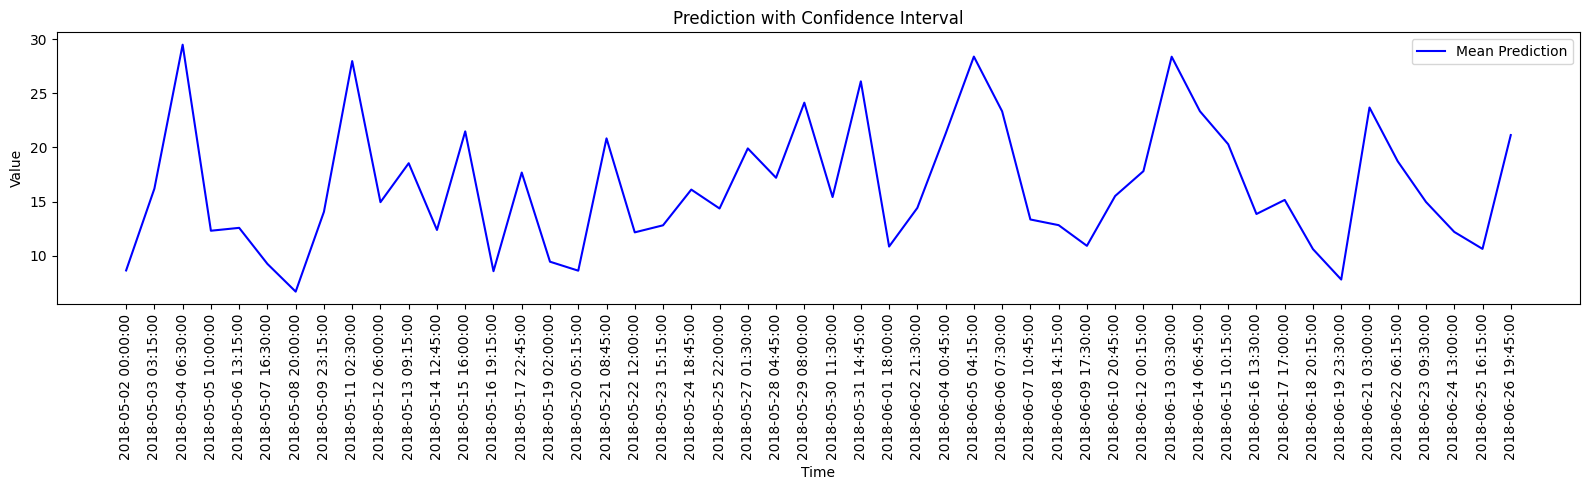

In [193]:
# x-> timestamp
# mean-> media (valor del medio)
# lower-> intevalo de confianza menor
# upper-> intervalo de confianza superior

plt.figure(figsize=(16, 5))
# plt.plot(test_df['date'], predictions_df['0.50'], label='Mean Prediction', color='blue')
n = 50  # number of x values to plot
sample_idxs = np.linspace(0, len(test_df)-1, n, dtype=int)
plt.plot(test_df['date'].iloc[sample_idxs], predictions_df['0.50'].iloc[sample_idxs], label='Mean Prediction', color='blue')
# plt.fill_between(predictions_df['0.50'].iloc[sample_idxs], [0.025], [0.95], color='blue', alpha=0.2, label='Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.title('Prediction with Confidence Interval')
plt.legend()
plt.tight_layout()
plt.show()

### **2. Prophet**

In [ ]:
model_prophet = Prophet(interval_width=0.95)
new_df = train_df.copy().reset_index().rename(columns={'index':'ds', 'value':'y'})

model_prophet.fit(new_df)
# Make Future Dataframe
future = model_prophet.make_future_dataframe(periods=len(test_df), freq='ME', include_history=False)
forecast = model_prophet.predict(future)

# Extract Predicted Values
predictions_prophet = forecast['yhat'].values[-len(test_df):]

# Calculate RMSE for Prophet
rmse_prophet = np.sqrt(mean_squared_error(test_df, predictions_prophet))
plot_and_validate(train_df, test_df, predictions_prophet, "Prophet Model")

# Use the plot with confidence intervals
model_prophet.plot(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

plot_components_plotly(m, forecast)

### **Pytorch Forecasting: MQF2DistributionLoss**

In [60]:
from pytorch_forecasting.metrics.distributions import MQF2DistributionLoss

In [ ]:
a = MQF2DistributionLoss()

### **Random Forest**

In [ ]:
sklearn_quantile.RandomForestQuantileRegressor

### **LSTM**